In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
from scipy.spatial import distance

# Path to your dataset
dataset_path = r"C:\ICE\SEM07\FYP\Datasets\FacesData-Prep\train"

# Initialize Mediapipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Landmarks to extract
selected_indices = {
    "Eyebrows": [21, 22, 23, 24],
    "Eyes": [36, 39, 41, 42, 45, 47],
    "Nose": [30, 31, 35],
    "Mouth": [48, 51, 54, 55, 61],
    "Jawline": [1, 9]
}
all_indices = [idx for indices in selected_indices.values() for idx in indices]

# Define pairs of landmarks for distance calculation
distance_pairs = [
    (21, 22),  # Eyebrow width
    (36, 39),  # Left eye width
    (42, 45),  # Right eye width
    (30, 48),  # Nose to mouth corner (left)
    (30, 54),  # Nose to mouth corner (right)
    (48, 54),  # Mouth width
    (1, 9),    # Jawline height
    (51, 61),  # Vertical mouth opening
    (21, 23)   # Vertical eyebrow distance
]

# Prepare output arrays
features = []
labels = []

# Iterate through the dataset
for label, folder in enumerate(['stress', 'non_stress']):
    folder_path = os.path.join(dataset_path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Load image
        image = cv2.imread(img_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process with Mediapipe
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Extract 2D landmarks
                landmark_coords = []
                for idx in all_indices:
                    x = face_landmarks.landmark[idx].x
                    y = face_landmarks.landmark[idx].y
                    landmark_coords.append((x, y))
                
                # Calculate inter-pupillary distance for normalization
                left_eye = landmark_coords[all_indices.index(36)]
                right_eye = landmark_coords[all_indices.index(42)]
                inter_pupillary_dist = distance.euclidean(left_eye, right_eye)

                # Calculate distances
                distances = []
                for pair in distance_pairs:
                    point1 = landmark_coords[all_indices.index(pair[0])]
                    point2 = landmark_coords[all_indices.index(pair[1])]
                    dist = distance.euclidean(point1, point2)
                    normalized_dist = dist / inter_pupillary_dist  # Normalize distance
                    distances.append(normalized_dist)

                # Calculate additional ratios as features
                mouth_width = distances[distance_pairs.index((48, 54))]
                mouth_height = distances[distance_pairs.index((51, 61))]
                if mouth_height > 0:  # Avoid division by zero
                    mouth_ratio = mouth_width / mouth_height
                else:
                    mouth_ratio = 0

                eyebrow_width = distances[distance_pairs.index((21, 22))]
                eyebrow_height = distances[distance_pairs.index((21, 23))]
                if eyebrow_height > 0:
                    eyebrow_ratio = eyebrow_width / eyebrow_height
                else:
                    eyebrow_ratio = 0

                # Append distances, ratios, and labels
                distances.extend([mouth_ratio, eyebrow_ratio])  # Add ratios to features
                features.append(distances)
                labels.append(label)

# Convert to NumPy arrays and save
features = np.array(features)
labels = np.array(labels)

np.save('features_distances_03.npy', features)
np.save('labels_03.npy', labels)

print("Feature extraction and distance calculation complete! Saved features and labels.")


KeyboardInterrupt: 

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}
Accuracy: 0.6600625651720542
Confusion Matrix:
 [[546 364]
 [288 720]]


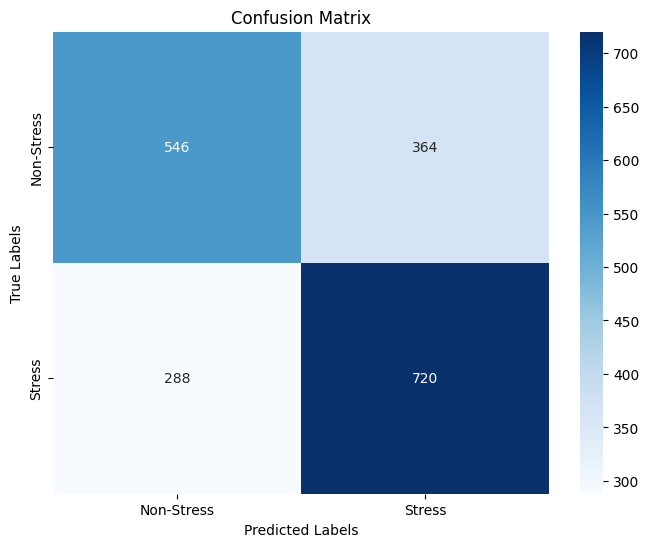

Classification Report:
              precision    recall  f1-score   support

  Non-Stress       0.65      0.60      0.63       910
      Stress       0.66      0.71      0.69      1008

    accuracy                           0.66      1918
   macro avg       0.66      0.66      0.66      1918
weighted avg       0.66      0.66      0.66      1918



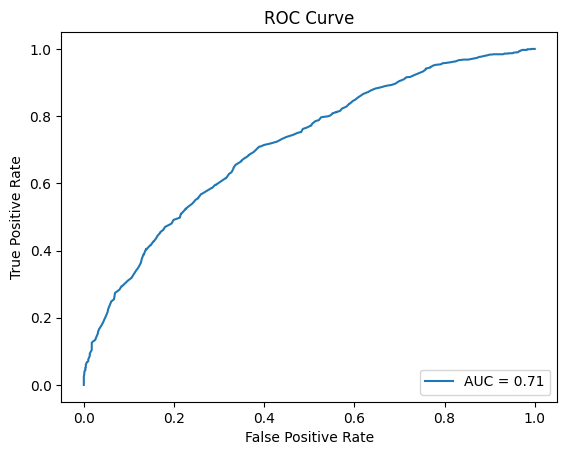

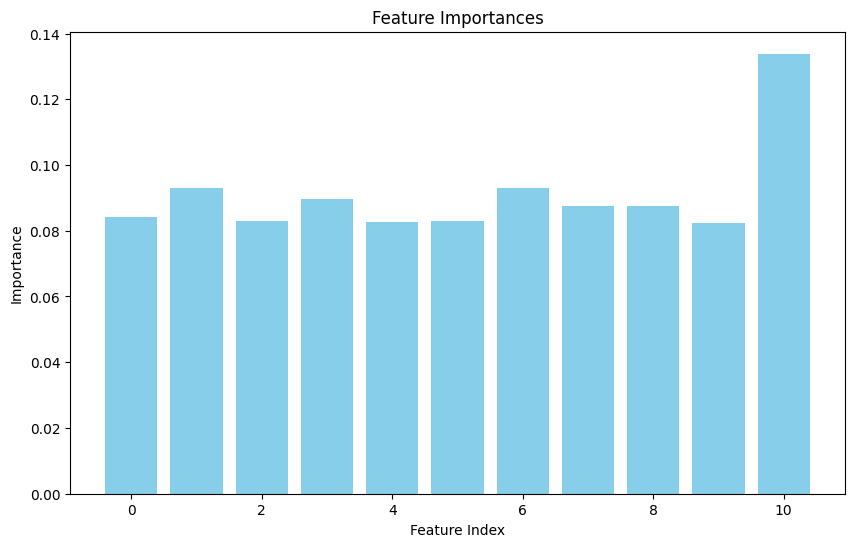

Cross-Validation Accuracy: 0.6503649635036497
Model saved as 'stress_detection_model_distance_04.pkl'


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load features and labels
features = np.load('features_distances_03.npy')  # Ensure this is the correct path
labels = np.load('labels_03.npy')  # Ensure this is the correct path

# Step 1: Data Preprocessing
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Optional: Apply PCA for dimensionality reduction (if features are very high-dimensional)
# pca = PCA(n_components=0.95)  # Retain 95% variance
# features_scaled = pca.fit_transform(features_scaled)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Step 3: Handle Class Imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 4: Hyperparameter Tuning with Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'class_weight': ['balanced', None]  # To handle class imbalance
}
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_smote, y_train_smote)

# Best parameters from Randomized Search
print("Best parameters:", random_search.best_params_)
model = random_search.best_estimator_

# Step 5: Train the model
model.fit(X_train_smote, y_train_smote)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Step 7: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Stress", "Stress"], yticklabels=["Non-Stress", "Stress"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 8: Additional Metrics - Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Stress", "Stress"]))

# Step 9: ROC Curve and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Step 10: Feature Importances
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Step 11: Cross-Validation (Optional)
cv_scores = cross_val_score(model, features_scaled, labels, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

# Step 12: Save the trained model
joblib.dump(model, 'stress_detection_model_distance_04.pkl')
joblib.dump(scaler, 'scaler_04.pkl')
print("Model saved as 'stress_detection_model_distance_04.pkl'")
